In [144]:
import data_query as dq
import testing_process as tp
import importlib
import pandas as pd
import json
import re
importlib.reload(dq)
importlib.reload(tp)
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [145]:
suggestion_query = '''
                    SELECT sls.prod_ver, sls.symptom_label, sls.message, sls.cycle_count,  slc.name as category, sls.repair_suggestion
                    FROM manufacturing_symptomlabelsuggestion sls
                    JOIN manufacturing_symptomlabelcategory slc
                    ON sls.category_id = slc.id;
                    '''
cat_df = tp.db_connect(suggestion_query)

In [146]:
# 1. last sn test date after April
# 2. prod_version is ACON or GLP
final_query = '''
SELECT 
    wo.model_name, wo.build_type, wo.production_version, mtr.serial_number, mtr.station,
    SUBSTRING(CAST(mtr.testing_date AS TEXT) FROM 1 FOR 19) AS testing_date,
    mtr.result, mtr.symptom_info, rm.failure_description, rm.result AS repair_result
FROM manufacturing_testingresult mtr
LEFT JOIN public.manufacturing_repairmain rm ON mtr.rowid = rm.testing_result_id
LEFT JOIN public.manufacturing_serialnumber msn ON mtr.serial_number = msn.serial_number
LEFT JOIN public.manufacturing_workorder wo ON msn.workorder_id = wo.workorder_id
WHERE EXISTS (
      SELECT 1
      FROM public.manufacturing_testingresult sub
      WHERE sub.serial_number = mtr.serial_number
        AND sub.testing_date between '2025-04-01' and '2025-04-30'
  )
  AND wo.production_version IN ('ACON', 'GLP')
ORDER BY mtr.serial_number, mtr.testing_date;
            '''
df = tp.db_connect(final_query)

In [147]:
from collections import defaultdict, Counter

def compute_cycle_counts(df):
    sn_label_tracker = defaultdict(Counter)

    results = []

    for idx, row in df.iterrows():
        sn = row['serial_number']
        failure_label = (row.get('failure_description') or '').strip()
        parsed = row.get('symptom_info')

        edge_case = None
        match_found = False
        match_msg = ''
        cycle_count = 0

        if not failure_label:
            edge_case = 'empty failure_description'
        elif not parsed or not isinstance(parsed, dict):
            edge_case = 'invalid or missing symptom_info'
        else:
            for detail in parsed.values():
                label = detail.get('symptom_label', '').strip()
                msg = detail.get('symptom_msg', '').strip()

                if label == failure_label:
                    match_found = True
                    match_msg = msg
                    sn_label_tracker[sn][label] += 1
                    cycle_count = sn_label_tracker[sn][label]
                    break

            if not match_found:
                edge_case = 'no label match'

        results.append({
            'cycle_count': max(1, cycle_count),
            'symptom_label_found': match_found,
            'symptom_msg_match': match_msg,
            'edge_case_reason': edge_case
        })

    for col in results[0].keys():
        df[col] = [r[col] for r in results]

    return df

repair_df = df[df['result']==0]
process_df = compute_cycle_counts(repair_df)

In [148]:
# TOP 80% labels
# Get value counts as Series
counts = process_df['failure_description'].value_counts(dropna=False)

# Convert to DataFrame
counts_df = counts.reset_index()
counts_df.columns = ['failure_description', 'count']

# Calculate percentage and cumulative percentage
counts_df['percent'] = counts_df['count'] / counts_df['count'].sum() * 100
counts_df['cumulative_percent'] = counts_df['percent'].cumsum()

# Optional: round for readability
counts_df['percent'] = counts_df['percent'].round(2)
counts_df['cumulative_percent'] = counts_df['cumulative_percent'].round(2)

top_label_df = counts_df[counts_df['cumulative_percent'] <= 90].copy()

In [149]:
# Step 1: Filter SNs that had at least one failure (repair_result == 0)
sn_with_failures = df[df["result"] == 0]["serial_number"].unique()
filtered_df = df[df["serial_number"].isin(sn_with_failures)]

# Step 3: Get the last record per SN
last_rows = filtered_df.groupby("serial_number").tail(1)

# Step 4: Keep only those SNs whose last row has repair_result == 0
# AND failure_description in top_label_df
valid_last_rows = last_rows[
    (last_rows["repair_result"] == 0) &
    (last_rows["failure_description"].isin(top_label_df["failure_description"]))
]

# Step 1: Create label order map
label_order_map = {label: i for i, label in enumerate(top_label_df["failure_description"])}

# Step 2: Group and select up to 5 SNs per label
final_sample = (
    valid_last_rows
    .sort_values(by=["failure_description", "serial_number"])  # ensure deterministic sampling
    .groupby("failure_description", sort=False)
    .head(5)
    .assign(label_order=lambda df_: df_["failure_description"].map(label_order_map))
    .sort_values("label_order")
)


In [ ]:
pattern_dict = {
    "Diorite SSH Connection Failed": ["Can not connect to Diorite IP:"],
    "Checking BMC boot readiness and get BMC IP Failed": [
        r"Switch to agora console failed.*", r"Failed to get IP address"
    ],
    "HB16 firmware check Failed": [
        r"Send command.*", r"Check HB16 version failed.*"
    ],
    "The sensor count of Config_check_HW is not matched.":[
        fr"OUTLET T {i}" for i in range(1, 4)
    ] + ["P48V VIN,volts"],
    "Validate Diorite PN, SN and installed slot Failed": lambda msg: [
        fr"usb_loc {port}.*Exception message:" 
        for port in ["1-1.1", "1-1.2", "1-1.7.1", "1-1.7.2"] if port in msg] + [
        fr"usb_loc {port}" 
        for port in ["1-1.1", "1-1.2", "1-1.7.1", "1-1.7.2"] if port in msg
    ],
    "Lower critical limit violated": [
        rf"^got \d+ violations, exceeding threshold of \d+ for sensor fan{fan} tach\."
        for fan in range(0, 6)] + [
        r"^got \d+ violations, exceeding threshold of \d+ for sensor .+\."
    ],
    "Diorite location validation failure": [
        r"component diorite sn: .*? not found on unit", r"component diorite sn \S+ location: \S+, expected location: \S+"
    ],
    "Create Host SSH Connection failed": [
        r"No address associated with hostname", r"Unable to connect to"
    ],
    "excessive-correctable-unclassified-cpu-errors": [
        fr"CPU{i} UNCLASSIFIED" for i in range(0,2)
    ],
    "Update Foxconn BIOS Failed" : [
        r"^Update BIOS failed\..*", r"^Update BIOS failed\.(\r\n)?Exception message:.*" 
    ],
    "Total Sensors fail": [
        fr"OUTLET T {i}" for i in range(1, 4)
    ] + [r"P48V"],
    "pcierrors-high-lane_error-rate": lambda msg: [
        rf"location: 0000:{b}:\d+\.\d+.*"
        for group in [
            {"00", "01"}, {"20", "21"}, {"40", "41"}, {"60", "61"},
            {"80", "81"}, {"a0", "a1"}, {"c0", "c1"}, {"e0", "e1"}
        ]
        for b in group
        if (bus := re.search(r"location: 0000:([a-fA-F0-9]{2})", msg)) and bus.group(1).lower() in group
    ] if re.search(r"location: 0000:([a-fA-F0-9]{2})", msg) else [],
    "Update Google BIOS Failed": [
        r"Send command '/export/hda3/meltan/biosintegrity/biosintegrity --expected_bios_version=.*?' failed\.\s*Failure Info:",
        r"Update BIOS failed\.\s*.*bios\.bin\s*.*bios\.sig"],
    "HB16 location validation failure": [
        r"Component HB16 SN: .*? not found on unit", r"Component HB16 SN \S+ location: \S+, expected location: \S+"
    ],
    "test-completion-missing-error-hwinterface_smoketest": [r"Diag execution failed."],
    "FRU infos validation failure": [
        # General pattern: Matches SN in the format "SN: xxxx yyyy not found on unit"
        r"(SN: [\w-]+ [\w-]+ not (found on unit|match unit)|PN:\s?[\w-]+ not (found on unit|match unit))",
        
        # Specific patterns for different components
        r"SN: PDF\w+ not found on unit",  # Matches NIC card starting with PDF
        r"SN: IPB\w+ not found on unit",  # Matches Gulp starting with IPB
        r"SN: AST\w+ not found on unit",  # Matches Mobo starting with AST
        r"SN: AAH\w+ not found on unit",  # Matches Agora starting with AAH
        r"SN: KW\w+-\w+ \w+ not found on unit",  # Matches Warthog starting with KW (with hyphen and space)
        r"SN: HAB\w+ not found on unit"   # Matches HB16 card starting with HAB
    ]

}


def analyze_label_messages(process_df, label, pattern_dict, cat_df):
    matched_examples = {}  # pattern -> one matching message
    matched_patterns = set()
    unmatched = []

    label_df = process_df[process_df['failure_description'] == label]

    print(f"\n=== Analysis for Label: '{label}' ===")

    if label in pattern_dict:  # Case 1: Label is in pattern_dict
        raw_pattern_entry = pattern_dict[label]

        for _, row in label_df.iterrows():
            msg = row['symptom_msg_match']
            cycle = row['cycle_count']
            ver = row['production_version']

            # Evaluate pattern dynamically per message if callable
            patterns = raw_pattern_entry(msg) if callable(raw_pattern_entry) else raw_pattern_entry

            matched = False
            for pattern in patterns:
                if re.search(pattern, msg, re.IGNORECASE | re.DOTALL):
                    matched = True
                    matched_patterns.add(pattern)
                    if pattern not in matched_examples:
                        matched_examples[pattern] = (msg, cycle, ver)
                    break

            if not matched:
                unmatched.append((msg, cycle, ver))

        # Print one matched example per matched pattern
        if matched_examples:
            print(f"\n=== MATCHED EXAMPLES ({len(matched_examples)}) ===")
            for pattern, (msg, cycle, ver) in matched_examples.items():
                print(f"\n[MATCHED EXAMPLE for pattern]\n{pattern}")
                print(f"→ Message: {msg}")
                print(f"→ cycle_count: {cycle}, prod_ver: {ver}")
        else:
            print("\n❌ No matched patterns at all.")


        # Print unmatched messages
        if unmatched:
            print(f"\n=== UNMATCHED MESSAGES ({len(unmatched)}) ===")
            for msg, cycle, ver in unmatched:
                print(f"[UNMATCHED] cycle_count: {cycle}, prod_ver: {ver}")
                print(f"{msg}\n")
        else:
            print("\n✅ All messages matched a pattern.")

    else:  # Case 2: Label not in pattern_dict
        print(f"\n[INFO] No patterns defined for label '{label}'. Comparing actual and standard messages...\n")

        seen = set()
        for _, row in label_df.iterrows():
            msg = row['symptom_msg_match']
            cycle = row['cycle_count']
            ver = row['production_version']

            key = (msg, cycle, ver)
            if key in seen:
                continue
            seen.add(key)

            # Find matching standard message in cat_df
            match_row = cat_df[
                (cat_df['symptom_label'] == label) &
                (cat_df['cycle_count'] == cycle) &
                (cat_df['prod_ver'] == ver)
            ]

            if not match_row.empty:
                std_msg = match_row.iloc[0]['message']
            else:
                std_msg = "[No standard message found]"

            print(f"[ACTUAL]   cycle_count: {cycle}, prod_ver: {ver}")
            print(f"{msg}\n")
            print(f"[STANDARD] {std_msg}\n{'-'*80}")
 
pd.set_option('display.max_colwidth', None)
unmatched_msgs = analyze_label_messages(process_df, "FRU infos validation failure", pattern_dict, cat_df)



=== Analysis for Label: 'FRU infos validation failure' ===

=== MATCHED EXAMPLES (6) ===

[MATCHED EXAMPLE for pattern]
(SN: [\w-]+ [\w-]+ not (found on unit|match unit)|PN:\s?[\w-]+ not (found on unit|match unit))
→ Message: Component FRU SN: 2411266-1 240432880 not found on unit
→ cycle_count: 1, prod_ver: ACON

[MATCHED EXAMPLE for pattern]
SN: IPB\w+ not found on unit
→ Message: Component SN: IPBFWI243101052 not found on unit
→ cycle_count: 1, prod_ver: GLP

[MATCHED EXAMPLE for pattern]
SN: HAB\w+ not found on unit
→ Message: Component SN: HABQTW242510239 not found on unit
→ cycle_count: 2, prod_ver: GLP

[MATCHED EXAMPLE for pattern]
SN: AST\w+ not found on unit
→ Message: Component FRU SN: ASTFWI243401463 not found on unit
→ cycle_count: 2, prod_ver: GLP

[MATCHED EXAMPLE for pattern]
SN: PDF\w+ not found on unit
→ Message: Component SN: PDFQMB244102368 not found on unit
→ cycle_count: 1, prod_ver: GLP

[MATCHED EXAMPLE for pattern]
SN: AAH\w+ not found on unit
→ Message: Compo

In [145]:
patterns = ["htool --usb_loc"]
pattern_regex = '|'.join(map(re.escape, patterns))
process_df[(process_df['failure_description']=='Validate Diorite PN, SN and installed slot Failed') &
           (process_df['symptom_msg_match'].str.contains(pattern_regex, na=False, regex=True))].shape[0]  \
/ process_df.shape[0]  

0.022799191734339853

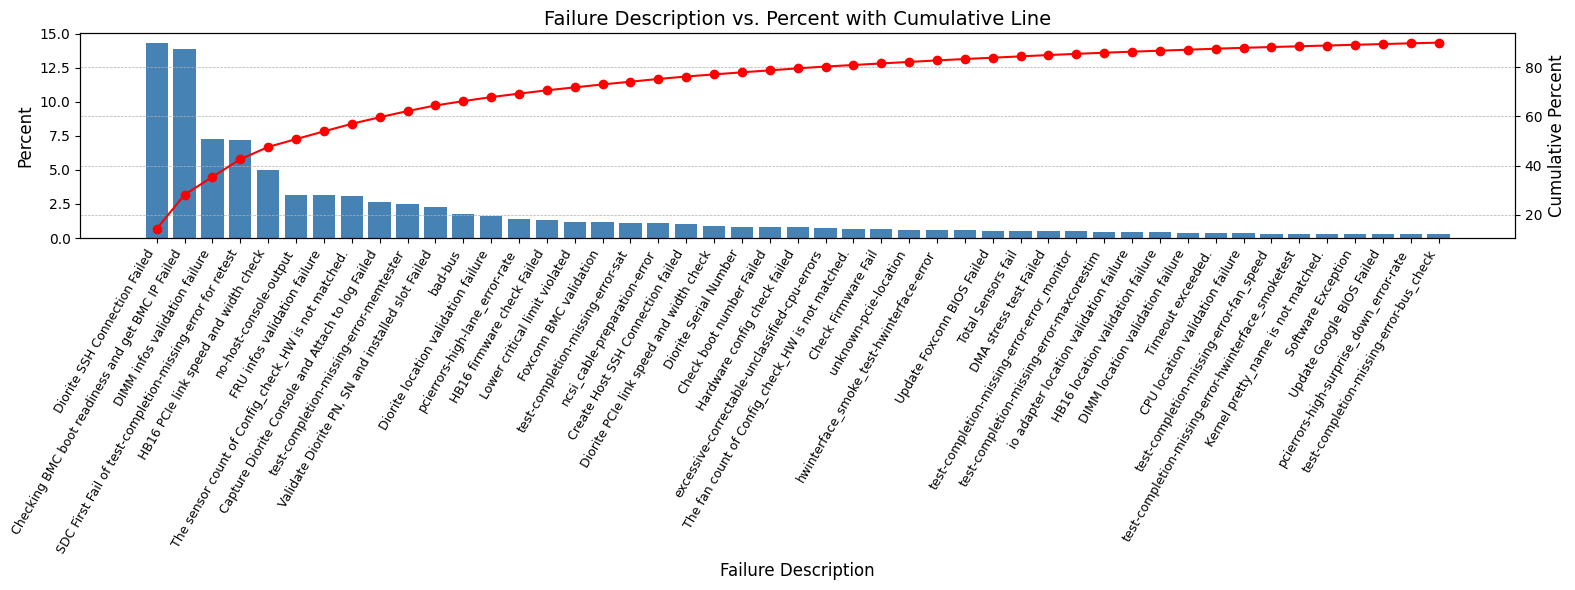

In [152]:
import matplotlib.pyplot as plt

# Set figure size for visibility
fig, ax1 = plt.subplots(figsize=(16, 6))

# Bar chart (left y-axis)
ax1.bar(top_label_df['failure_description'], top_label_df['percent'], color='steelblue')
ax1.set_ylabel('Percent', fontsize=12)
ax1.set_xlabel('Failure Description', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)

# Rotate x-axis labels and align them
ax1.set_xticklabels(top_label_df['failure_description'], rotation=60, ha='right', fontsize=9)

# Line chart (right y-axis)
ax2 = ax1.twinx()
ax2.plot(top_label_df['failure_description'], top_label_df['cumulative_percent'], color='red', marker='o')
ax2.set_ylabel('Cumulative Percent', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)

# Add grid, title, and tight layout
plt.title('Failure Description vs. Percent with Cumulative Line', fontsize=14)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

In [90]:
pd.set_option('display.max_colwidth', None)
label = top_label_df.failure_description.iloc[10]
print(label)
filter_mess = cat_df[(cat_df['symptom_label']== label)&(cat_df['cycle_count'] == 1)&(cat_df['prod_ver'].str.contains('GLP'))]
for i in filter_mess.iterrows():
    print("message:")
    print(i[1][2])

Validate Diorite PN, SN and installed slot Failed
message:
Send command 'htool --usb_loc 1-1.1 target reset on' failed.
message:
Send command 'htool --usb_loc 1-1.1 target reset on' failed.
Failure Info:
Exception message: Timeout opening channel.
message:
Send command 'htool --usb_loc 1-1.2 target reset on' failed.
message:
Send command 'htool --usb_loc 1-1.2 target reset on' failed.
Failure Info:
Exception message: Timeout opening channel.
message:
Send command 'htool --usb_loc 1-1.7.1 target reset on' failed.
message:
Send command 'htool --usb_loc 1-1.7.1 target reset on' failed.
Failure Info:
Exception message: Timeout opening channel.
message:
Send command 'htool --usb_loc 1-1.7.2 target reset on' failed.
message:
Send command 'htool --usb_loc 1-1.7.2 target reset on' failed.
Failure Info:
Exception message: Timeout opening channel.


In [129]:
found_labels = top_label_df['failure_description'].isin(cat_df['symptom_label'])
top_label_df['label_in_cat'] = found_labels
# Only those labels that matched
matched_cat_df = cat_df[cat_df['symptom_label'].isin(top_label_df['failure_description'])]
unmatched_labels = top_label_df[~top_label_df['failure_description'].isin(cat_df['symptom_label'])]

In [130]:
len(matched_cat_df.symptom_label.unique()), len(unmatched_labels.failure_description.unique())
unmatched_labels[['failure_description', 'percent']]

,failure_description,percent
3,SDC First Fail of test-completion-missing-error for retest,7.23
4,HB16 PCIe link speed and width check,5.02
16,Foxconn BMC validation,1.19
20,Diorite PCIe link speed and width check,0.87
28,,0.56
30,hwinterface_smoke_test-hwinterface-error,0.55
35,io adapter location validation failure,0.42
41,Kernel pretty_name is not matched.,0.31
44,Software Exception,0.30
45,pcierrors-high-surprise_down_error-rate,0.30


In [80]:
kk = process_df[process_df['failure_description'] == 'pcierrors-high-surprise_down_error-rate']
label_msg_pairs = []
label_set = set()
for info in kk["symptom_info"]:
    if isinstance(info, dict):
        for sub_dict in info.values():
            label = sub_dict.get("symptom_label", "").strip()
            message = sub_dict.get("symptom_msg", "").strip()
            label_set.add(label)
            if label and message:
                label_msg_pairs.append((label, message))
label_msg_pairs = sorted(label_msg_pairs, key=lambda x: x[0])

# Define the updated patterns for matching the pcie error and error types
pattern_error = r"PCIe serial number: .+, location: .+, devpath: .+ pcie error are (exceeding|below) thresholds\."
pattern_error_type = r"PCIe serial number: .+, location: .+, devpath: .+ pcie error, Error Types: '[\w_]+?' are (exceeding|below) thresholds\."

# Function to find and display labels based on patterns
def find_labels_by_patterns(label_msg_pairs):
    matched_pcie_labels = set()  # To track unique labels for 'pcie error'
    matched_error_type_labels = set()  # To track unique labels for 'error types'
    unmatched_labels = set()  # To track labels that do not match either pattern
    
    # Iterate through the label-message pairs
    for label, message in label_msg_pairs:
        # Check if the message matches pattern_error
        if re.match(pattern_error, message) and label not in matched_pcie_labels:
            print(f"pcie: {label}")
            matched_pcie_labels.add(label)
        
        # Check if the message matches pattern_error_type
        if re.match(pattern_error_type, message) and label not in matched_error_type_labels:
            print(f"error_type: {label}, example message: {message}")
            matched_error_type_labels.add(label)
        
        # If no match for either pattern, add to unmatched_labels
        if label not in matched_pcie_labels and label not in matched_error_type_labels:
            unmatched_labels.add(label)
    
    # Print unmatched labels
    if unmatched_labels:
        print("\nUnmatched labels:")
        for label in unmatched_labels:
            print(label)
        return matched_pcie_labels, matched_error_type_labels, unmatched_labels

matched_pcie_labels,matched_error_type_labels,  unmatched_labels= find_labels_by_patterns(label_msg_pairs)
# Combine the results into the desired print order: matched_pcie_labels, matched_error_type_labels, unmatched_labels
all_labels_in_order = list(matched_pcie_labels) + list(matched_error_type_labels) + list(unmatched_labels)

# Iterate through the labels in the desired order and print the first example message for each
for label in all_labels_in_order:
    # Find the first example message for each label
    example_message = next((message for lbl, message in label_msg_pairs if lbl == label), None)
    if example_message:
        print(f"label: {label}, example message: {example_message}")

error_type: pcierrors-high-bad_dllp-rate, example message: PCIe serial number: 2468056-1 2501308PR, location: 0000:a1:00.0, devpath: /phys/PE5/IO0:device:0000_a1_00_0_11f8_4100_11f8_beef pcie error, Error Types: 'BAD_DLLP' are exceeding thresholds.
error_type: pcierrors-high-bad_tlp-rate, example message: PCIe serial number: 2468056-1 2501308PR, location: 0000:a1:00.0, devpath: /phys/PE5/IO0:device:0000_a1_00_0_11f8_4100_11f8_beef pcie error, Error Types: 'BAD_TLP' are exceeding thresholds.
error_type: pcierrors-high-completion_timeout-rate, example message: PCIe serial number: 9ACQ813N40100, location: 0000:80:01.1, devpath: /phys/CPU1:device:nbio0.0:pcie_root@bridge:port1.1 pcie error, Error Types: 'COMPLETION_TIMEOUT' are exceeding thresholds.
error_type: pcierrors-high-data_link_protocol_error-rate, example message: PCIe serial number: 9ACQ813N40100, location: 0000:a0:01.1, devpath: /phys/CPU1:device:nbio0.1:pcie_root@bridge:port1.1 pcie error, Error Types: 'DATA_LINK_PROTOCOL_ERROR

In [369]:
test_query = '''
    SELECT 
    wo.model_name, wo.production_version, mtr.serial_number, mtr.station,
    SUBSTRING(CAST(msn.complete_date AS TEXT) FROM 1 FOR 19) complete_date,
    SUBSTRING(CAST(mtr.testing_date AS TEXT) FROM 1 FOR 19) AS testing_date,
    SUBSTRING(CAST(rm.repaired_date AS TEXT) FROM 1 FOR 19) AS repaired_date,
    mtr.result test_result, rm.result AS repair_result, mtr.symptom_info, rm.failure_description,
    sls.symptom_label, message, cycle_count, slc.name
    FROM public.manufacturing_serialnumber msn
    LEFT JOIN manufacturing_testingresult mtr on msn.serial_number = mtr.serial_number
    LEFT JOIN public.manufacturing_repairmain rm ON mtr.rowid = rm.testing_result_id
    LEFT JOIN public.manufacturing_workorder wo ON msn.workorder_id = wo.workorder_id
    LEFT JOIN public.manufacturing_repairdetail rd ON rm.failure_sequence = rd.failure_sequence
    LEFT JOIN public.manufacturing_symptomlabelsuggestion sls ON rd.symptom_suggestion_id = sls.id
    LEFT JOIN public.manufacturing_symptomlabelcategory slc ON sls.category_id = slc.id
    WHERE msn.complete_date >= '2025-04-01'
    AND msn.completed = 1 AND msn.station_id = 'Pack' AND wo.production_version in ('ACON', 'GLP')
    AND mtr.serial_number IN (
        -- Ensure serial numbers have at least one result = 0 and one non-null symptom_suggestion_id
        SELECT mtr_sub.serial_number
        FROM manufacturing_testingresult mtr_sub
        LEFT JOIN public.manufacturing_repairmain rm_sub ON mtr_sub.rowid = rm_sub.testing_result_id
        LEFT JOIN public.manufacturing_repairdetail rd_sub ON rm_sub.failure_sequence = rd_sub.failure_sequence
        WHERE mtr_sub.result = 0 
        GROUP BY mtr_sub.serial_number
    )
    ORDER BY mtr.serial_number, msn.complete_date, mtr.testing_date, rm.repaired_date;
'''
res = tp.db_connect(test_query)

In [370]:
cols_to_check = res.columns.difference(['symptom_info', 'failure_description'])
res_deduped = res.drop_duplicates(subset=cols_to_check)

In [559]:
res_deduped['repaired_date'] = pd.to_datetime(res_deduped['repaired_date'])
len(res_deduped[(res_deduped['repaired_date']>='2025-03-07')&(res_deduped['repaired_date']<='2025-03-30')].serial_number.unique()

918

In [575]:
# each SN first / last repair date
first_repair_date = res_deduped[res_deduped['repaired_date'].notna()]\
    .groupby('serial_number')['repaired_date'].min()

last_repair_date = res_deduped[res_deduped['repaired_date'].notna()]\
    .groupby('serial_number')['repaired_date'].max()

res_deduped['group'] = 'unknown'

# AFTER: first record after 5/7 
after_sns = first_repair_date[first_repair_date >= '2025-05-07'].index
res_deduped.loc[res_deduped['serial_number'].isin(after_sns), 'group'] = 'after'

# BEFORE: first and last date before 5/7
before_sns = last_repair_date[
    (first_repair_date > '2025-03-17') &
    (last_repair_date < '2025-04-15')
].index
res_deduped.loc[res_deduped['serial_number'].isin(before_sns), 'group'] = 'before'

# HYBRID: rest of the SN
hybrid_sns = res_deduped[
    (res_deduped['group'] == 'unknown') &
    (res_deduped['serial_number'].notna())
]['serial_number'].unique()

res_deduped.loc[res_deduped['serial_number'].isin(hybrid_sns), 'group'] = 'hybrid'



In [576]:
sn_group = res_deduped[['serial_number', 'group']].drop_duplicates()
group_counts = sn_group['group'].value_counts().reset_index()
group_counts.columns = ['group', 'sn_count']
group_counts

,group,sn_count
0,hybrid,9748
1,after,6465
2,before,5855


In [580]:

before_df = res_deduped[res_deduped['group']=='before'].copy()
after_df = res_deduped[res_deduped['group']=='after'].copy()

In [445]:
test_df = after_df.copy().reset_index(drop=True)

for sn in test_df["serial_number"].dropna().unique():
    sn_group = test_df[test_df["serial_number"] == sn]

    # Step 2: Update symptom_label and message
    for idx in sn_group.index:
        row = test_df.loc[idx]
        info_dict = row["symptom_info"]
        if (
            isinstance(info_dict, dict) and len(info_dict) > 0 and
            pd.isna(row["symptom_label"]) and row["test_result"] == 0
        ):
            for item in info_dict.values():
                if item.get("symptom_label") == row["failure_description"]:
                    test_df.at[idx, "symptom_label"] = item["symptom_label"]
                    test_df.at[idx, "message"] = item.get("symptom_msg", "")
                    break

    # Filter only test_result == 0 rows
    valid_idxs = sn_group[sn_group["test_result"] == 0].index

    # Step 3: Reassign cycle_count only for valid rows
    label_counter = {}
    for idx in valid_idxs:
        label = test_df.at[idx, "symptom_label"]
        if pd.notna(label):
            label_counter[label] = label_counter.get(label, 0) + 1
            test_df.at[idx, "cycle_count"] = label_counter[label]

    # Step 4: Match name (category) only for valid rows
    for idx in valid_idxs:
        row = test_df.loc[idx]
        if pd.notna(row["symptom_label"]) and pd.notna(row["cycle_count"]):
            matched = cat_df[
                (cat_df["prod_ver"] == row["production_version"]) &
                (cat_df["cycle_count"] == row["cycle_count"]) &
                (cat_df["symptom_label"] == row["symptom_label"])
            ]
            if not matched.empty:
                test_df.at[idx, "name"] = matched.iloc[0]["category"]


In [451]:
# Step 1: Filter rows where test_result == 0 and name is not null
valid_df = test_df[
    (test_df["test_result"] == 0) &
    (test_df["name"].notna())
]

# Step 2: Keep only SNs that appear more than once in that filtered result
duplicate_sn = valid_df["serial_number"].value_counts()
duplicate_sn = duplicate_sn[duplicate_sn > 1].index

# Step 3: Final result: only rows with duplicated SNs
filtered_df = valid_df[valid_df["serial_number"].isin(duplicate_sn)]



,model_name,production_version,serial_number,station,complete_date,testing_date,repaired_date,test_result,repair_result,symptom_info,failure_description,symptom_label,message,cycle_count,name,group
0,ASTORIA,GLP,FWI2434-09791,AST Functional Test,2025-05-14 18:08:21,2025-04-16 23:48:23,2025-05-13 12:05:16,0,1.0,{'SymptomRunKey_9cff5c1c-1962-488b-ab5d-448641...,"Validate Diorite PN, SN and installed slot Failed","Validate Diorite PN, SN and installed slot Failed",Send command 'htool --usb_loc 1-1.7.1 target r...,1.0,REPAIR 2,after
1,ASTORIA,GLP,FWI2434-09791,AST Functional Test,2025-05-14 18:08:21,2025-05-13 13:26:22,2025-05-13 20:53:14,0,1.0,{'SymptomRunKey_adc33d33-bf63-4b6e-bb69-7a69d5...,"Validate Diorite PN, SN and installed slot Failed","Validate Diorite PN, SN and installed slot Failed",Send command 'htool --usb_loc 1-1.7.1 target r...,2.0,DEBUG 1,after
27,ASTORIA,ACON,FWI2445-02064,AST Functional Test,2025-05-31 21:34:54,2025-04-08 12:21:23,2025-05-12 02:07:50,0,1.0,{'SymptomRunKey_7e461111-0ebe-424e-b450-3b6fb5...,DIMM infos validation failure,DIMM infos validation failure,Component DIMM SN: (L)64GB 2RX4 PC5-4800B-RA0-...,1.0,REPAIR 1,after
28,ASTORIA,ACON,FWI2445-02064,AST Functional Test,2025-05-31 21:34:54,2025-05-12 09:07:23,2025-05-12 13:12:25,0,1.0,{'SymptomRunKey_1878fed2-a2ba-4d2a-96ab-79818c...,Diorite SSH Connection Failed,Diorite SSH Connection Failed,Create Diorite SSH Connection failed.\nCan not...,1.0,RETEST,after
46,ASTORIA,GLP,FWI2447-09170,AST Pre-Test,2025-05-27 04:08:53,2025-01-09 22:22:33,2025-05-14 15:38:22,0,1.0,{'SymptomRunKey_765b525d-dc5f-4281-89d5-fa8505...,FRU infos validation failure,FRU infos validation failure,Component [NIC card] SN: PDFCTH244003800 not f...,1.0,REPAIR 2,after
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36941,ASTORIA,ACON,FWI2522-06209,AST Functional Test,2025-06-02 07:35:06,2025-05-31 15:51:32,2025-05-31 16:13:48,0,1.0,{'SymptomRunKey_812a5155-9bfc-46b6-8acf-17cb22...,Diorite SSH Connection Failed,Diorite SSH Connection Failed,Create Diorite SSH Connection failed.\r\nCan n...,1.0,RETEST,after
36942,ASTORIA,ACON,FWI2522-06209,AST Functional Test,2025-06-02 07:35:06,2025-05-31 17:38:55,2025-05-31 17:52:03,0,1.0,{'SymptomRunKey_13217508-5c50-42cc-809f-6bef1b...,Diorite SSH Connection Failed,Diorite SSH Connection Failed,Create Diorite SSH Connection failed.\r\nCan n...,2.0,REPAIR 2,after
37067,ASTORIA,ACON,FWI2522-06415,AST Functional Test,2025-06-02 07:47:15,2025-05-31 12:29:18,2025-05-31 13:55:11,0,1.0,{'SymptomRunKey_276783df-e7ac-483e-8c6a-5adf96...,Diorite SSH Connection Failed,Diorite SSH Connection Failed,Create Diorite SSH Connection failed.\r\nCan n...,1.0,RETEST,after
37068,ASTORIA,ACON,FWI2522-06415,AST Functional Test,2025-06-02 07:47:15,2025-05-31 15:28:09,2025-05-31 15:38:50,0,1.0,{'SymptomRunKey_15131623-04a2-4707-a237-93b1c4...,Diorite SSH Connection Failed,Diorite SSH Connection Failed,Create Diorite SSH Connection failed.\r\nCan n...,2.0,REPAIR 2,after


In [494]:
df = filtered_df.copy()

# Get previous category for each SN + label
df["prev_category"] = df.groupby(["serial_number", "symptom_label"])["name"].shift()

# Only keep rows where a transition occurred (prev != current)
category_transitions = df[df["prev_category"].notna() & (df["prev_category"] != df["name"])]

# Count each transition: label + prev_cat → new_cat
transition_counts = (
    category_transitions
    .groupby(["symptom_label", "prev_category", "name"])
    .size()
    .reset_index(name="count")
)
transition_bases = (
    test_df[test_df["test_result"] == 0]
    .groupby(["symptom_label", "name"])
    .size()
    .reset_index(name="base_count")
    .rename(columns={"name": "prev_category"})  # match transition key
)
transition_summary = transition_counts.merge(
    transition_bases,
    on=["symptom_label", "prev_category"],
    how="left"
)

transition_summary["transition_rate"] = transition_summary["count"] / transition_summary["base_count"]

# Optional: sort
transition_summary.sort_values("transition_rate", ascending=False, inplace=True)

In [520]:
transition_summary[transition_summary['count']>1].head(10)

,symptom_label,prev_category,name,count,base_count,transition_rate
50,pcierrors-high-lane_error-rate,DEBUG 1,DEBUG 2,5,8,0.625000
12,Diorite SSH Connection Failed,DEBUG 1,DEBUG 2,13,28,0.464286
28,The fan count of Config_check_HW is not matched.,REPAIR 1,DEBUG 1,9,22,0.409091
42,Validate route of DUT Failed,DEBUG 1,DEBUG 2,2,5,0.400000
2,Checking BMC boot readiness and get BMC IP Failed,DEBUG 1,DEBUG 2,11,29,0.379310
27,The fan count of Config_check_HW is not matched.,DEBUG 1,DEBUG 2,3,9,0.333333
26,Send command fail: stressapptest -s 30 -m 128 ...,RETEST,REPAIR 1,2,7,0.285714
49,no-host-console-output,REPAIR 1,DEBUG 1,34,124,0.274194
24,Mobo boot failed,RETEST,DEBUG 1,3,11,0.272727
9,DIMM infos validation failure,REPAIR 1,DEBUG 1,127,495,0.256566


In [472]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from collections import defaultdict

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# Step 1: convert each SN into a list of labels by cycle order
sn_label_sequences = (
    filtered_df.copy()
    .groupby("serial_number")["symptom_label"]
    .apply(list)
    .tolist()
)

from prefixspan import PrefixSpan

# Run PrefixSpan on your sequences
ps = PrefixSpan(sn_label_sequences)

# Find top 100 patterns first (or higher than 20 to ensure we catch useful ones)
raw_patterns = ps.topk(k=100)

# Filter: keep only patterns with length > 1
multi_step_patterns = [
    (support, pattern)
    for support, pattern in raw_patterns
    if len(pattern) > 1
]

# Optional: further filter to exclude repeated-label patterns like ['A', 'A']
multi_label_patterns = [
    (support, pattern)
    for support, pattern in multi_step_patterns
    if len(set(pattern)) > 1
]

# Display results
print("📈 Top frequent multi-step, multi-label sequences:\n")
for support, pattern in multi_label_patterns[:20]:  # show top 20 of filtered
    print(f"Support: {support}  Pattern: {pattern}")



📈 Top frequent multi-step, multi-label sequences:

Support: 47  Pattern: ['Diorite SSH Connection Failed', 'Checking BMC boot readiness and get BMC IP Failed']
Support: 34  Pattern: ['Checking BMC boot readiness and get BMC IP Failed', 'Diorite SSH Connection Failed']
Support: 22  Pattern: ['Checking BMC boot readiness and get BMC IP Failed', 'DIMM infos validation failure']
Support: 20  Pattern: ['DIMM infos validation failure', 'Checking BMC boot readiness and get BMC IP Failed']
Support: 20  Pattern: ['DIMM infos validation failure', 'Diorite SSH Connection Failed']
Support: 19  Pattern: ['Diorite SSH Connection Failed', 'DIMM infos validation failure']
Support: 18  Pattern: ['The sensor count of Config_check_HW is not matched.', 'Checking BMC boot readiness and get BMC IP Failed']
Support: 16  Pattern: ['Diorite SSH Connection Failed', 'The sensor count of Config_check_HW is not matched.']
Support: 15  Pattern: ['Attach booting logs to OTC failed.', 'Checking BMC boot readiness and

In [556]:
hybrid_df = res_deduped[res_deduped['group']=='hybrid'].copy()
hybrid_before = hybrid_df[(hybrid_df['test_result']==0)&(hybrid_df['repaired_date']<'2025-04-20')]
hybrid_after = hybrid_df[(hybrid_df['test_result']==0)&(hybrid_df['repaired_date']>='2025-04-20')]

In [553]:
hybrid_df.shape

(24911, 16)

In [549]:
hybrid_after.groupby('serial_number').size().mean()

np.float64(2.13356067064507)

In [582]:
# Define what counts as a repair loop: test_result = 0 and repaired_date exists
before_df['is_loop'] = (before_df['test_result'] == 0) & (before_df['repaired_date'].notna())
after_df['is_loop'] = (after_df['test_result'] == 0) & (after_df['repaired_date'].notna())

# Count number of loops per SN
loop_counts_before = before_df[before_df['is_loop']].groupby('serial_number').size()
loop_counts_after = after_df[after_df['is_loop']].groupby('serial_number').size()
# Sample from the larger group: loop_counts_after
sampled_loop_counts_after = loop_counts_after.sample(n=len(loop_counts_before), random_state=42)

# Compute the averages using matched sample sizes
avg_loops_before = loop_counts_before.mean()
avg_loops_after = sampled_loop_counts_after.mean()

print(f"[SAMPLED] Average repair loops BEFORE 2025-05-07: {avg_loops_before:.2f}")
print(f"          Average repair loops AFTER  2025-05-07: {avg_loops_after:.2f}")




[SAMPLED] Average repair loops BEFORE 2025-05-07: 1.57
          Average repair loops AFTER  2025-05-07: 1.51


C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_14260\1986616816.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([loop_counts_before, loop_counts_after], labels=['Before', 'After'])


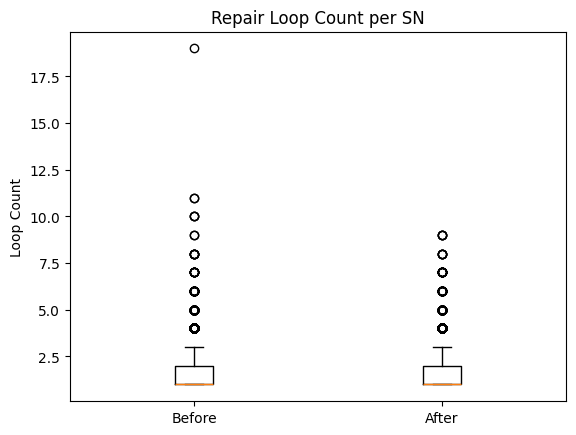

In [583]:
import matplotlib.pyplot as plt

plt.boxplot([loop_counts_before, loop_counts_after], labels=['Before', 'After'])
plt.title("Repair Loop Count per SN")
plt.ylabel("Loop Count")
plt.show()


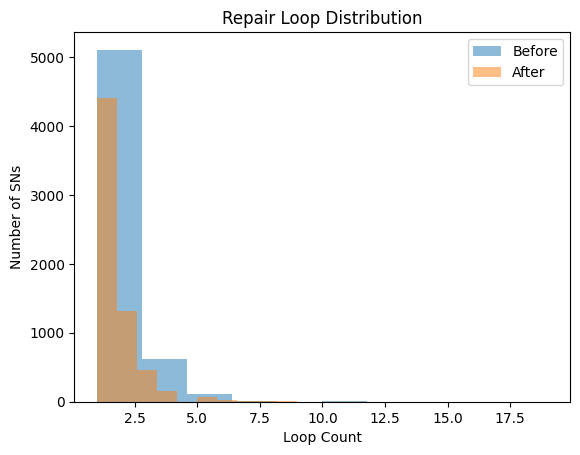

In [584]:
plt.hist(loop_counts_before, bins=10, alpha=0.5, label='Before')
plt.hist(loop_counts_after, bins=10, alpha=0.5, label='After')
plt.legend()
plt.title("Repair Loop Distribution")
plt.xlabel("Loop Count")
plt.ylabel("Number of SNs")
plt.show()


In [585]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(loop_counts_before, loop_counts_after, alternative='two-sided')
print(f"Mann–Whitney U test p-value: {p_value:.4f}")


Mann–Whitney U test p-value: 0.0004


In [586]:

# Step 1: Filter only RETEST rows
retest_df = after_df[after_df['name'] == 'REPAIR 1'].copy()
retest_df['solved_next'] = False

# Step 2: Loop through each SN
for sn in retest_df['serial_number'].unique():
    # Sort rows for this SN in order of testing_date — keep original index!
    sn_rows = after_df[after_df['serial_number'] == sn].sort_values('testing_date')

    for i in range(len(sn_rows) - 1):
        current_row = sn_rows.iloc[i]
        next_row = sn_rows.iloc[i + 1]
        current_idx = sn_rows.index[i]

        # RETEST failed, check if next test passed
        if current_row['name'] == 'RETEST' and current_row['test_result'] == 0:
            if next_row['test_result'] == 1:
                if current_idx in retest_df.index:
                    retest_df.at[current_idx, 'solved_next'] = True

In [587]:
total_retest = len(retest_df)
solved_once = retest_df['solved_next'].sum()
ratio = solved_once / total_retest

print(f"RETEST total: {total_retest}")
print(f"One-time solves: {solved_once}")
print(f"Success rate: {ratio:.2%}")

RETEST total: 1499
One-time solves: 0
Success rate: 0.00%


In [632]:
def compute_resolution_time(group):
    group = group.sort_values('testing_date')  # Ensure correct order
    
    # First time sent for repair
    repaired_dates = group['repaired_date'].dropna()
    if repaired_dates.empty:
        return None
    first_repair = repaired_dates.min()
    
    # Last fail (test_result == 0)
    fail_times = group[group['test_result'] == 0]['testing_date']
    if fail_times.empty:
        return None
    last_fail_time = fail_times.max()
    
    # Find first test_result == 1 after that failure
    follow_up = group[(group['testing_date'] > last_fail_time) & (group['test_result'] == 1)]
    if follow_up.empty:
        return None
    resolved_time = follow_up['testing_date'].iloc[0]
    return (resolved_time - first_repair).total_seconds() / 3600


after_df['testing_date'] = pd.to_datetime(after_df['testing_date'])
after_df['repaired_date'] = pd.to_datetime(after_df['repaired_date'])
resolution_times_after = after_df.groupby('serial_number').apply(compute_resolution_time).dropna()

avg_resolution = resolution_times_after.mean()
print(f"Average Repaired Hours：{avg_resolution:.2f} hours")


Average Repaired Hours：18.40 hours


C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_14260\2507175513.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resolution_times_after = after_df.groupby('serial_number').apply(compute_resolution_time).dropna()


In [ ]:
before_df['testing_date'] = pd.to_datetime(before_df['testing_date'])
before_df['repaired_date'] = pd.to_datetime(before_df['repaired_date'])

resolution_times_before = before_df.groupby('serial_number').apply(compute_resolution_time).dropna()
avg_resolution = resolution_times_before.mean()
print(f"Average Repaired Hours：{avg_resolution:.2f} hours")

Average Repaired Hours：34.03 hours


C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_14260\311243061.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resolution_times_before = before_df.groupby('serial_number').apply(compute_resolution_time).dropna()


In [592]:
min_len = min(len(resolution_times_before), len(resolution_times_after))

sampled_before = resolution_times_before.sample(n=min_len, random_state=42)
sampled_after = resolution_times_after.sample(n=min_len, random_state=42)
print(f"Average Resolution Time BEFORE: {sampled_before.mean():.2f} hrs")
print(f"Average Resolution Time AFTER : {sampled_after.mean():.2f} hrs")


Average Resolution Time BEFORE: 34.03 hrs
Average Resolution Time AFTER : 18.40 hrs


In [633]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(resolution_times_before, resolution_times_after, alternative='two-sided')
print(f"Mann–Whitney U test p-value: {p_value:.4f}")

Mann–Whitney U test p-value: 0.0007


In [596]:
(34.03 - 18.40) / 34.03

0.45930061710255665

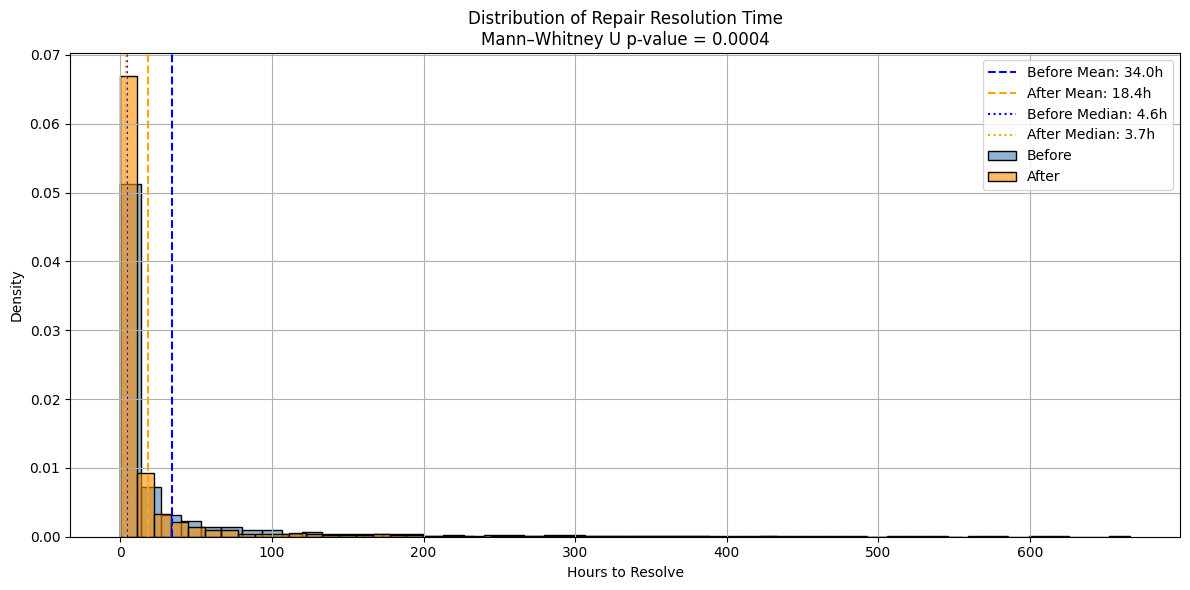

In [634]:
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np
# Calculate mean and median
mean_before = resolution_times_before.mean()
mean_after = resolution_times_after.mean()
median_before = np.median(resolution_times_before)
median_after = np.median(resolution_times_after)

# Perform Mann–Whitney U test
stat, p_value = mannwhitneyu(resolution_times_before, resolution_times_after, alternative='greater')

# Compute % of SNs resolved within 24h
within_24h_before = (resolution_times_before <= 24).mean() * 100
within_24h_after = (resolution_times_after <= 24).mean() * 100

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(resolution_times_before, bins=50, color='steelblue', label='Before', stat='density', kde=False, alpha=0.6)
sns.histplot(resolution_times_after, bins=50, color='darkorange', label='After', stat='density', kde=False, alpha=0.6)

# Mean and median lines
plt.axvline(mean_before, color='blue', linestyle='--', label=f'Before Mean: {mean_before:.1f}h')
plt.axvline(mean_after, color='orange', linestyle='--', label=f'After Mean: {mean_after:.1f}h')
plt.axvline(median_before, color='blue', linestyle=':', label=f'Before Median: {median_before:.1f}h')
plt.axvline(median_after, color='orange', linestyle=':', label=f'After Median: {median_after:.1f}h')

# Labels
plt.title(f'Distribution of Repair Resolution Time\nMann–Whitney U p-value = {p_value:.4f}')
plt.xlabel('Hours to Resolve')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create summary table
summary = pd.DataFrame({
    'Group': ['Before', 'After'],
    'Mean (h)': [mean_before, mean_after],
    'Median (h)': [median_before, median_after],
    'Resolved ≤24h (%)': [within_24h_before, within_24h_after]
})



In [635]:
summary

,Group,Mean (h),Median (h),Resolved ≤24h (%)
0,Before,34.030463,4.555833,76.453488
1,After,18.401966,3.672083,85.241337


In [3]:
from collections import defaultdict
import json
import pandas as pd

def extract_label(df):
    df["Label_Dict"] = [{} for _ in range(len(df))]
    df["msg_dict"] = [{} for _ in range(len(df))]

    if "testing_date" in df.columns:
        df.sort_values(by=["serial_number", "testing_date"], inplace=True)

    mask = df["test_result"] == 0
    sn_label_history = defaultdict(lambda: defaultdict(int))

    def process_row(row):
        sn = row["serial_number"]

        # Parse symptom_info safely
        try:
            symptom_data = json.loads(row["symptom_info"]) if isinstance(row["symptom_info"], str) else (row["symptom_info"] or {})
        except Exception:
            symptom_data = {}

        # Normalize failure_description
        desc = row.get("failure_description", "")
        has_desc = pd.notna(desc) and desc.strip()
        normalized_desc = desc.strip().lower() if has_desc else None

        # Extract label-message pairs from symptom_info
        label_msg_map = {}
        if isinstance(symptom_data, dict):
            for v in symptom_data.values():
                label = v.get("symptom_label", "").strip().lower()
                msg = v.get("symptom_msg", "").strip()
                if label:
                    label_msg_map[label] = msg

        # Decide final labels
        if normalized_desc and normalized_desc in label_msg_map:
            final_labels = [normalized_desc]
            msg_dict = {normalized_desc: label_msg_map[normalized_desc]}
        else:
            final_labels = list(label_msg_map.keys())
            msg_dict = label_msg_map.copy()

        # Build label_dict using sn-label history
        label_dict = {}
        for label in final_labels:
            sn_label_history[sn][label] += 1
            label_dict[label] = sn_label_history[sn][label]

        return pd.Series({
            "Label_Dict": label_dict,
            "msg_dict": msg_dict
        })

    df.loc[mask, ["Label_Dict", "msg_dict"]] = df[mask].apply(process_row, axis=1)

    return df


In [4]:
df_copy = df.copy()
label_df = extract_label(df_copy)

In [125]:
model = ['ASTORIA', "ATHENA", "FLATBACK", "RACKBACK", "GULP"]
build = ['GA', 'PROD']
station = ['AST Pre-Test']
filter_label_df = label_df[(label_df['model_name'].isin(model)) 
                        #    & (label_df['build_type'].isin(build)) 
                        #    & (label_df['station'].isin(station))
                           ]

In [126]:
model_station_dict = filter_label_df.groupby("model_name")["station"].apply(lambda x: sorted(x.dropna().unique())).to_dict()

In [127]:
def top_k_labels_by_model_station(df, model_station_dict, top_k=5):
    records = []
    # Filter only failed rows
    failed_df = df[df["test_result"] == 0]

    for model, station_list in model_station_dict.items():
        for station in station_list:
            group_df = failed_df[(failed_df["model_name"] == model) &(failed_df["station"] == station)]
            if group_df.empty:
                continue

            label_counter = Counter()
            for row in group_df["Label_Dict"]:
                label_counter.update(row.keys())

            top_labels = label_counter.most_common(top_k)
            row_data = {"model_name": model,"station": station}

            for i, (label, count) in enumerate(top_labels, start=1):
                row_data[f"{i}st_label"] = label
                row_data[f"{i}st_count"] = count

            records.append(row_data)
    result_df = pd.DataFrame(records)
    # Find all "count" columns
    count_cols = [col for col in result_df.columns if col.endswith("_count")]
    # Convert them to nullable integers
    result_df[count_cols] = result_df[count_cols].astype("Int64")
    # Drop rows that have any NaNs in count columns
    result_df = result_df.dropna(subset=count_cols)
    return result_df


In [128]:
top_k_labels_by_model_station(label_df, model_station_dict, top_k=5)

,model_name,station,1st_label,1st_count,2st_label,2st_count,3st_label,3st_count,4st_label,4st_count,5st_label,5st_count
0,ASTORIA,AST Functional Test,checking bmc boot readiness and get bmc ip failed,6925,diorite ssh connection failed,6100,dimm infos validation failure,4254,diorite sanity check failed,3158,the sensor count of config_check_hw is not mat...,1704
1,ASTORIA,AST Google Firmware Update Test,attach booting logs to otc failed.,495,update google bios failed,473,capture diorite console and attach to log failed,365,update google bmc failed,238,diorite ssh connection failed,197
3,ASTORIA,AST Pre-Test,hb16 pcie link speed and width check failed,6478,hb16 pcie link speed and width check,5874,diorite ssh connection failed,4461,checking bmc boot readiness and get bmc ip failed,4304,fru infos validation failure,4115
4,ASTORIA,AST Run-in Test,test-completion-missing-error-memtester,1823,test-completion-missing-error-sat,1100,the sensor count of config_check_hw is not mat...,825,diorite ssh connection failed,703,total sensors fail,512
6,ASTORIA,AST SDC Test,rsync-error,4415,sdc first fail of test-completion-missing-erro...,3304,test-completion-missing-error-maxcorestim,2736,test-completion-missing-error-rainbow,1401,test-completion-missing-error-dna,1034
7,ASTORIA,Turin Pre-Firmware Update Test,host-compute-node-boot-timeout,197,ac cycle by console step fail,196,check dut connections failed,163,nvmessd-mfg-step-asic-detect-error,142,checking bmc boot readiness and get bmc ip failed,116
8,ATHENA,ATH Firmware Update,ddr training failed,905,connect to bmc console failed,441,connect to cn0 console failed,298,telnet to bmc failed,247,pcie training failed,227
9,ATHENA,ATH Functional Test,ddr training failed,269,meltan bom check failed:node1node2,138,system sensor counts did not match,138,ti failed,130,find failaure from bios information,112
10,ATHENA,ATH Google Firmware Update Test,agora gbmc firmware version did not match,62,checking agora gbmc firmware version info.,25,checking bmc firmware version info.,22,connect to bmc console failed,18,upgrade bmc failed,14
11,ATHENA,ATH Run-in Test,ti failed,1555,meltan power virus1 failedpv,322,meltan power virus1 failed:node1node2pv,288,service is not ready,153,error: mdc ecc failed,109


In [130]:
final_query = '''
                SELECT 
                    wo.model_name, wo.build_type, wo.skuno, mtr.serial_number,
                    mtr.station,
                    SUBSTRING(CAST(mtr.testing_date AS TEXT) FROM 1 FOR 19) AS testing_date,
                    SUBSTRING(CAST(msn.complete_date AS TEXT) FROM 1 FOR 19) AS complete_date,
                    SUBSTRING(CAST(rm.repaired_date AS TEXT) FROM 1 FOR 19) AS repaired_date,
                    mtr.result AS test_result,
                    rm.result AS repair_result,
                    mtr.symptom_info,
                    rm.failure_description,
                    rd.repair_code,
                    rd.repaired_description
                FROM manufacturing_testingresult mtr
                LEFT JOIN public.manufacturing_repairmain rm ON mtr.rowid = rm.testing_result_id
                LEFT JOIN public.manufacturing_serialnumber msn ON mtr.serial_number = msn.serial_number
                LEFT JOIN public.manufacturing_repairdetail rd ON rm.failure_sequence = rd.failure_sequence
                LEFT JOIN public.manufacturing_workorder wo ON msn.workorder_id = wo.workorder_id
                WHERE wo.model_name = 'ASTORIA' AND mtr.result = 0 AND rm.result = 1 AND msn.complete_date > '2025-01-01' AND wo.build_type in ('GA', 'PROD')
                -- Filtering failed tests only
                ORDER BY mtr.serial_number, rm.repaired_date ASC;
            '''
df = tp.db_connect(final_query)

In [132]:
repair_df_copy = df.copy()
repair_label_df = extract_label(repair_df_copy)
repair_label_df = repair_label_df.drop(columns=['symptom_info', 'failure_description'], axis=1)

In [141]:
label_occurrence = Counter()
for d in repair_label_df[repair_label_df['test_result'] == 0]["Label_Dict"]:
    label_occurrence.update(d.keys())

In [44]:
query = '''
 SELECT 
    wo.model_name, wo.build_type, wo.skuno, mtr.serial_number,
    mtr.station,
    SUBSTRING(CAST(rm.repaired_date AS TEXT) FROM 1 FOR 19) AS repaired_date,
    mtr.symptom_info,
    rm.failure_description,
    mtr.result
FROM manufacturing_testingresult mtr
LEFT JOIN public.manufacturing_repairmain rm ON mtr.rowid = rm.testing_result_id
LEFT JOIN public.manufacturing_serialnumber msn ON mtr.serial_number = msn.serial_number
LEFT JOIN public.manufacturing_workorder wo ON msn.workorder_id = wo.workorder_id
WHERE wo.model_name = 'ASTORIA' AND mtr.result = 0 AND rm.result = 0 and msn.complete_date > '2025-01-01' AND wo.build_type in ('GA', 'PROD')
-- Filtering failed tests only
ORDER BY mtr.serial_number, rm.repaired_date ASC;
'''
df = tp.db_connect(query)

In [29]:
result_df = tp.process_symptom_info(df)
processed_result_df = tp.compute_label_cycles(result_df)

{('fru infos validation failure',
  'component fru sn: aahivt245001305 not found on unit'): 1}

In [30]:
debug_df = pd.read_excel('debug_tree.xlsx', header=[0, 1])
# Rename columns properly
debug_df.columns = ["symptom_label", "symptom_message", "cycle1_cat", "cycle1_suggestion", "cycle2_cat", "cycle2_suggestion", "cycle3+_cat", "cycle3+_suggestion"]
# Fill down `symptom_label` column and apply stripping/lowering
debug_df["symptom_label"] = debug_df["symptom_label"].ffill().str.strip().str.lower()

# Apply stripping and lowering to `symptom_message` column
debug_df["symptom_message"] = debug_df["symptom_message"].astype(str).str.strip().str.lower()

In [53]:
single_label = processed_result_df[processed_result_df['label_cycle'].apply(lambda x: len(x) == 1)]
multi_label = processed_result_df[processed_result_df['label_cycle'].apply(lambda x: len(x) > 1)] # cases of no failure description
single_label_message = single_label[single_label['label_message_cycle'].apply(lambda x: len(x) == 1)]
single_label_multi_message = single_label[single_label['label_message_cycle'].apply(lambda x: len(x) > 1)]

In [146]:
def single_label_message_debug_with_pattern_matching(processed_result_df, debug_df, match_dict):
    """
    Updates processed_result_df by:
    1. Matching labels/messages using regex-based pattern matching.
    2. Tracking cycle counts per serial_number to ensure counts start at 1.
    3. Assigning category & suggestion based on debug_df.

    Parameters:
    - processed_result_df: DataFrame with label_cycle and label_message_cycle.
    - debug_df: DataFrame with symptom_label, symptom_message, and cycle-based category/suggestions.
    - match_dict: Dictionary containing regex patterns for label matching.

    Returns:
    - Updated DataFrame with new columns:
      - Category (dict)
      - Suggestion (dict)
      - Label_Cycle_Count (int)
      - Message_Cycle_Count (int)
    """

    processed_result_df_copy = processed_result_df.copy()

    # ✅ Step 1: Convert debug_df into a lookup dictionary
    debug_dict = {}
    for _, row in debug_df.iterrows():
        debug_label = row["symptom_label"]
        debug_message = row["symptom_message"]
        debug_dict.setdefault(debug_label, {})[debug_message] = row  # Store full row for lookup
    # ✅ Step 2: Initialize tracking for label & message counts per serial_number
    serial_label_count = {}  # {serial_number: {label_pattern: count}}
    serial_label_message_count = {}  # {serial_number: {(label_pattern, message): count}}

    # New columns to be added
    categories, suggestions = [], []
    label_cycle_counts, message_cycle_counts = [], []

    # ✅ Step 3: Iterate over `processed_result_df`
    for index, row in processed_result_df_copy.iterrows():
        serial_number = row["serial_number"]
        label_message_cycle = row["label_message_cycle"]  # Extract {(label, message): count}
        # Initialize tracking for this serial_number if not exists
        if serial_number not in serial_label_count:
            serial_label_count[serial_number] = {}
            serial_label_message_count[serial_number] = {}

        category_dict, suggestion_dict = {}, {}

        # ✅ Initialize counts to ensure they are always assigned
        label_count = 1  # Default to 1 if no match found
        message_count = 1  # Default to 1 if no match found

        found_match = False  # Track if a match was found

        for (label, message), _ in label_message_cycle.items():
            print((label, message))
            matched_label = None

            # ✅ Step 4: Find matching label in `match_dict`
            for pattern_label in match_dict.keys():
                if re.fullmatch(pattern_label, label, re.IGNORECASE) or re.search(pattern_label, label, re.IGNORECASE):
                    matched_label = pattern_label
                    break  # Stop after first match

            if not matched_label:
                continue  # No match, skip

            found_match = True  # Mark that at least one match was found

            # ✅ Step 5: Determine cycle counts based on previous occurrences
            previous_label_counts = [
                count for prev_label, count in serial_label_count[serial_number].items()
                if re.fullmatch(matched_label, prev_label, re.IGNORECASE) or re.search(matched_label, prev_label, re.IGNORECASE)
            ]
            label_count = max(previous_label_counts) + 1 if previous_label_counts else 1  # Ensure first occurrence is 1

            previous_message_counts = [
                count for (prev_label, prev_message), count in serial_label_message_count[serial_number].items()
                if (re.fullmatch(matched_label, prev_label, re.IGNORECASE) or re.search(matched_label, prev_label, re.IGNORECASE))
                and prev_message == message  # Match message exactly
            ]
            message_count = max(previous_message_counts) + 1 if previous_message_counts else 1

            # ✅ Step 6: Store updated counts
            serial_label_count[serial_number][label] = label_count
            serial_label_message_count[serial_number][(label, message)] = message_count

            # ✅ Step 7: Assign category & suggestion based on cycle count
            if (label, message) in debug_dict:
                print(debug_dict)
                for i in [1, 2, "3+"]:
                    if message_count == i or (message_count >= 3 and i == "3+"):
                        category_dict[message] = debug_dict[(label, message)].get(f"cycle{i}_cat", "")
                        suggestion_dict[message] = debug_dict[(label, message)].get(f"cycle{i}_suggestion", "")
                print("there", label)
            elif label in debug_df["symptom_label"].values:
                print("here", label)
                for _, label_row in debug_df[debug_df["symptom_label"] == label].iterrows():
                    msg_text = label_row["symptom_message"]
                    for i in [1, 2, "3+"]:
                        if label_count == i or (label_count >= 3 and i == "3+"):
                            category_dict[msg_text] = label_row.get(f"cycle{i}_cat", "")
                            suggestion_dict[msg_text] = label_row.get(f"cycle{i}_suggestion", "")
            else:
                print("wow")
                print(label, message)
        # ✅ Ensure `label_count` and `message_count` are at least 1 even if no match was found
        if not found_match:
            label_count = 1
            message_count = 1

        # ✅ Step 8: Append results
        categories.append(category_dict if category_dict else {})
        suggestions.append(suggestion_dict if suggestion_dict else {})
        label_cycle_counts.append(label_count)
        message_cycle_counts.append(message_count)

    # ✅ Step 9: Update DataFrame with new columns
    processed_result_df_copy["Category"] = categories
    processed_result_df_copy["Suggestion"] = suggestions
    processed_result_df_copy["Label_Cycle_Count"] = label_cycle_counts
    processed_result_df_copy["Message_Cycle_Count"] = message_cycle_counts

    return processed_result_df_copy

x = single_label_message_debug_with_pattern_matching(single_label_message, debug_df, match_criteria)

('fru infos validation failure', 'component fru sn: aahivt245001305 not found on unit')
('fru infos validation failure', 'component fru sn: aahfwi245110571 not found on unit')
('update google bmc failed', 'send command \'/export/hda3/meltan/bmcintegrity/bmcintegrity --expected_bmc_version="gbmc_23.6.36.200"\' failed.\nfailure info:\nexception message: timeout opening channel.\ntraceback (most recent call last):\n  file "/home/abmx/opentest.485658b/astoria.v4.0.11.5.1/custom/utils/sshconn.py", line 139, in send_ssh_cmd\n    stdin, stdout, stderr = self.ssh.exec_command(cmd, timeout=timeout)\n  file "/usr/local/lib/python3.10/dist-packages/paramiko/client.py", line 508, in exec_command\n    chan = self._transport.open_session(timeout=timeout)\n  file "/usr/local/lib/python3.10/dist-packages/paramiko/transport.py", line 875, in open_session\n    return self.open_channel(\n  file "/usr/local/lib/python3.10/dist-packages/paramiko/transport.py", line 1010, in open_channel\n    raise sshexcep